<a href="https://www.kaggle.com/code/binisme/csgo-gun-detections?scriptVersionId=200544127" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from PIL import Image
import torchvision.transforms as transforms
import torch
from torchvision import datasets
from torch.utils.data import Dataset
import os

In [2]:
num_workers = 4
batch_size = 20

In [3]:
# from the pytorch torchvision models documentation
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([transforms.Resize(320),
                                      transforms.CenterCrop(256),
                                      transforms.RandomAffine(90),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(30),
                                      transforms.RandomVerticalFlip(),
                                      transforms.ToTensor(),
                                      normalize])

test_transform = transforms.Compose([transforms.Resize(size=(256, 256)),
                                     transforms.ToTensor(),
                                     normalize])

train_data = datasets.ImageFolder('/kaggle/input/csgo-guns-dataset/Train', transform=train_transform)
test_data = datasets.ImageFolder('/kaggle/input/csgo-guns-dataset/Test', transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data,
                                           batch_size=batch_size,
                                           shuffle=False,
                                           num_workers=num_workers)

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
use_cuda = torch.cuda.is_available()

# CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(8*8*128, 500)
        self.fc2 = nn.Linear(500, 33)
        
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        # forward behavior
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        # flatten 3d tensor into 2d 
        x = x.view(-1, 8*8*128)
        
        # apply dropout to prevent overfit
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        
        return x

model_scratch = Net()

if use_cuda:
    model_scratch.cuda()
    
criterion_scratch = nn.CrossEntropyLoss()
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.05)

In [5]:
loaders = {
    'train': train_loader,
    'test': test_loader
}

In [6]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda):
    """returns trained model"""

    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        
        # train the model #

        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # find loss and update model parameters

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))

        # print statistics 
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch, 
            train_loss))
            
    # return trained model
    return model

def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [7]:
# train model
model_scratch = train(15, loaders, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda)

Epoch: 1 	Training Loss: 3.391594
Epoch: 2 	Training Loss: 3.215881
Epoch: 3 	Training Loss: 3.130075
Epoch: 4 	Training Loss: 3.039388
Epoch: 5 	Training Loss: 2.966313
Epoch: 6 	Training Loss: 2.927757
Epoch: 7 	Training Loss: 2.769044
Epoch: 8 	Training Loss: 2.679880
Epoch: 9 	Training Loss: 2.561272
Epoch: 10 	Training Loss: 2.469883
Epoch: 11 	Training Loss: 2.135987
Epoch: 12 	Training Loss: 1.960443
Epoch: 13 	Training Loss: 2.032814
Epoch: 14 	Training Loss: 1.907641
Epoch: 15 	Training Loss: 1.680902


In [8]:
# test model    
test(loaders, model_scratch, criterion_scratch, use_cuda)

Test Loss: 5.166621


Test Accuracy:  7% ( 5/66)


In [9]:
from PIL import Image
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt                        
from PIL import Image
%matplotlib inline
import glob

def load_input_image(img_path):    
    image = Image.open(img_path).convert('RGB')
    prediction_transform = transforms.Compose([transforms.Resize(size=(256, 256)),
                                     transforms.ToTensor(), 
                                     normalize])
    image = prediction_transform(image)[:3,:,:].unsqueeze(0)
    return image

def predict_gun(model, class_names, img_path):
    # load image and return predicted gun
    img = load_input_image(img_path)
    model = model.cpu()
    model.eval()
    with torch.no_grad():
        idx = torch.argmax(model(img))
    return class_names[idx]

def run_app(img_path, model):
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')  # Hide axes for better visualization
    plt.show()
    predict = predict_gun(model, class_names, img_path)
    print('This gun looks like a(n) {}'.format(predict))
    return predict

test_imgs = np.array(glob.glob("/kaggle/input/csgo-guns-dataset/Test/*/*"))

# Get class names from the training set
class_names = [item[:] for item in loaders['train'].dataset.classes]

def loop_run_app(test_path, model):
    # Initialize counters for accuracy calculation
    correct_predictions = 0
    total_predictions = 0

    # Iterate over a subset of test images
    for path in test_path[:40:2]:
        print(f"Evaluating image: {path}")
        predicted_class = run_app(path, model)

        # Extract the true class from the path (assuming class name is part of the path)
        true_class = path.split('/')[-2]  # Adjust this based on the structure of your paths

        # Compare the predicted class with the true class
        if predicted_class == true_class:
            correct_predictions += 1
        total_predictions += 1

    # Calculate accuracy
    accuracy = 100.0 * correct_predictions / total_predictions if total_predictions > 0 else 0
    print(f"\nAccuracy: {accuracy:.2f}% ({correct_predictions}/{total_predictions})")

Evaluating image: /kaggle/input/csgo-guns-dataset/Test/Five_Seven/weapon_fiveseven_so_red_light_large.29ae7b2264bd2a390ecf51a51293d2c2202fdea9.png


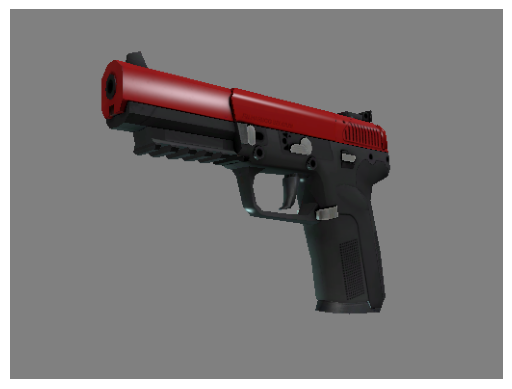

This gun looks like a(n) P-90
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/M4A1/weapon_m4a1_silencer_hy_varicamo_light_large.794803daec1d6d6cd2c47d8e8520d9f5f0b1fc1b.png


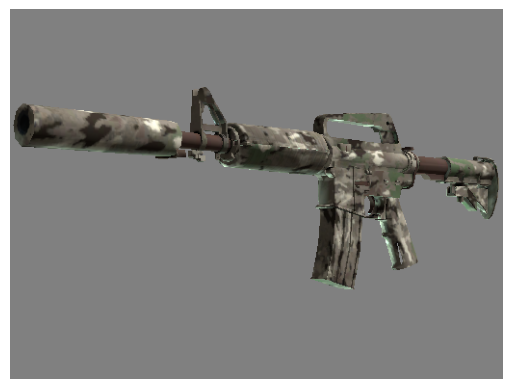

This gun looks like a(n) UMP
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/UMP/weapon_ump45_sp_ump45_d-visions_light_large.33ae7e9e8bf24ee97f4f3d3ee113e51782a756fa.png


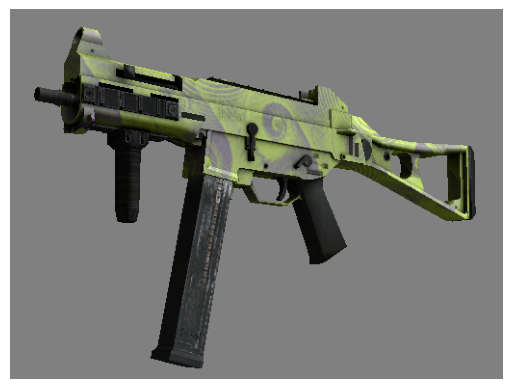

This gun looks like a(n) P-90
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/Aug/weapon_aug_sp_nukestripe_orange_aug_light_large.4309138bd5b9e518628d517a275747ec9c2207d3.jpg


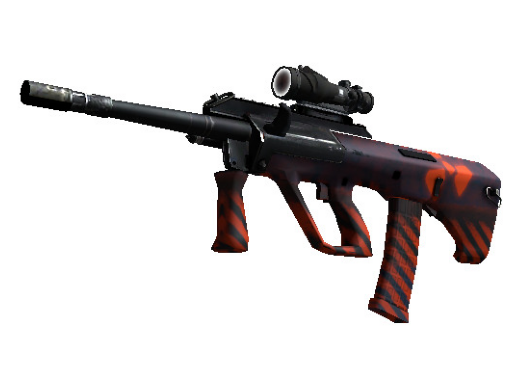

This gun looks like a(n) CZ-75
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/MP-5/weapon_mp5sd_sp_tape_short_rally_light_large.2fdb10eba1dbf17030a2c0867fc385fe0449b974.png


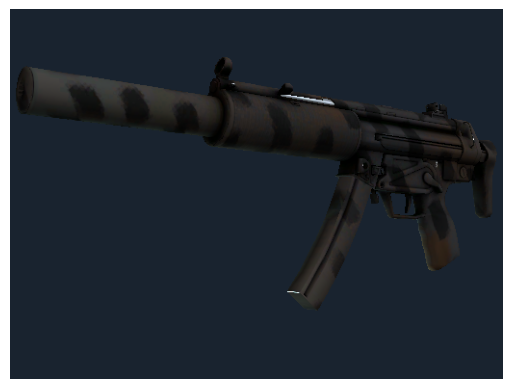

This gun looks like a(n) MAC-10
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/MAC-10/weapon_mac10_sp_palm_light_large.22a3296d079e27cb7bb291e15eff10c29aa89b3e.png


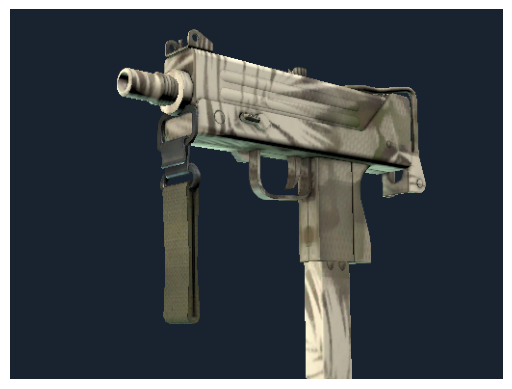

This gun looks like a(n) MP-9
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/Sawed-Off/weapon_sawedoff_sp_spray_desert_sage_light_large.e944ddb90e97199d1f274c481462a3a660b9fc5a.png


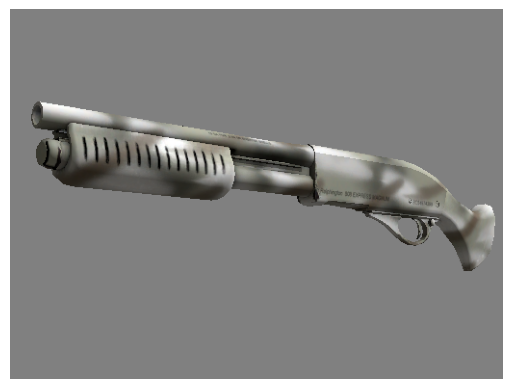

This gun looks like a(n) P250
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/MP-7/weapon_mp7_sp_tape_orange_light_large.5870d3d214c5b4cd923d68c4a016b72596808db1.png


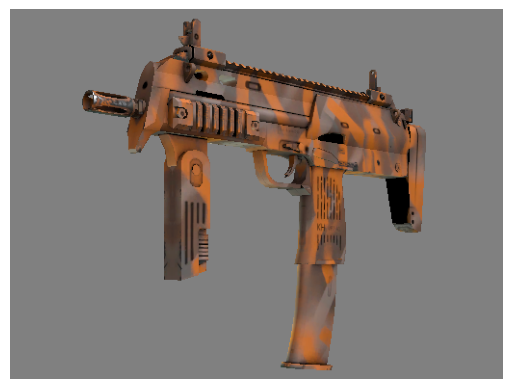

This gun looks like a(n) P-90
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/P-2000/weapon_hkp2000_sp_leaves_grassland_light_large.a7885e449e09718b530a5f8e4b79a30931f104cb.png


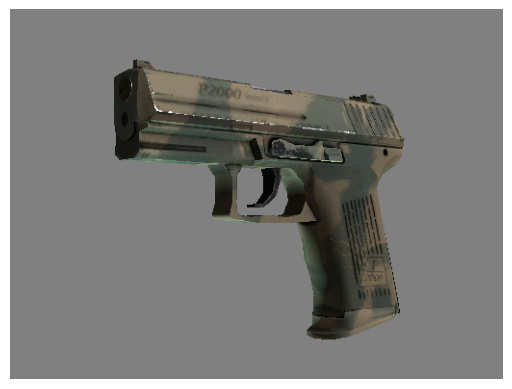

This gun looks like a(n) Scout
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/G3SG1/weapon_g3sg1_sp_tape_short_jungle_light_large.02fd06db8f950789b6c4bff265df06439382c585.png


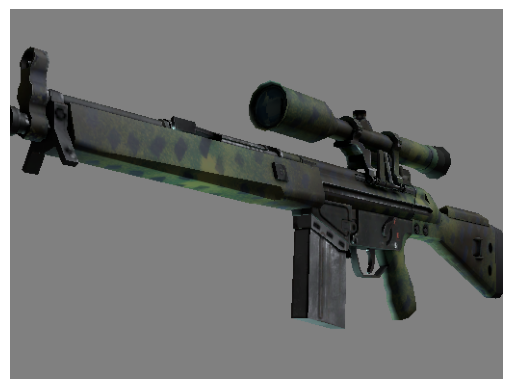

This gun looks like a(n) P-90
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/dual_pistol/weapon_elite_sp_elites_winter_raider_light_large.eddc2e91d0081e57588b745589209094a6b3e9b6.jpg


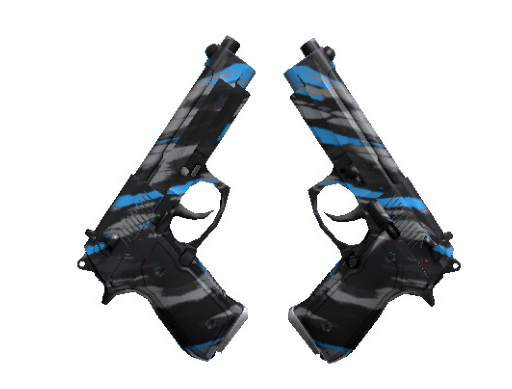

This gun looks like a(n) AK-47
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/P250/weapon_p250_sp_splash_p250_light_large.9270d8d14c39aef83407ea50e51f0eb89c17263d.png


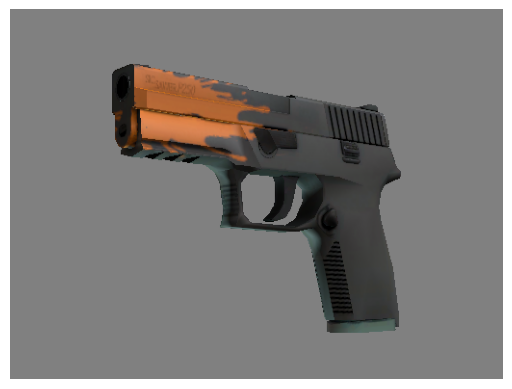

This gun looks like a(n) Scout
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/M249/weapon_m249_sp_mesh_python_light_large.39f20f5499a7d68e8b90a9e064c993e9a803d721.png


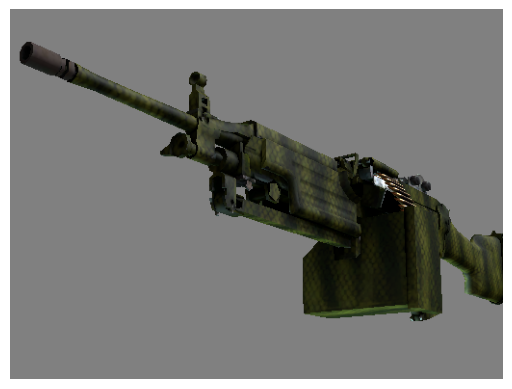

This gun looks like a(n) MP-9
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/USP/weapon_usp_silencer_sp_leaves_light_large.a71c8dc482fea4aaa1c6b5c115e370a7e134ddfd.png


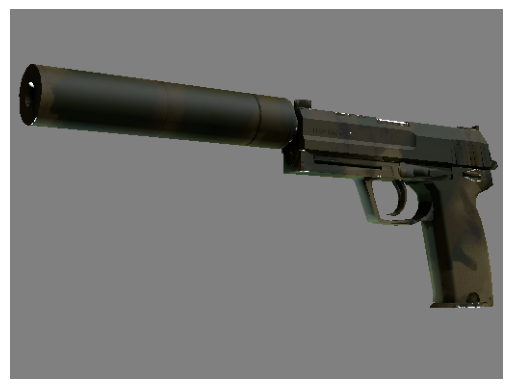

This gun looks like a(n) M4A4
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/Scar-20/weapon_scar20_sp_palm_light_large.ed935d932711961605c3b03b896560f4ebfe8861.png


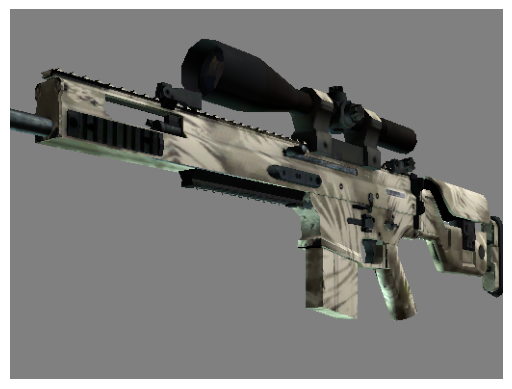

This gun looks like a(n) P-90
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/Revolver/weapon_revolver_sp_spray_water_light_large.0f7d074b7c53419d9475b0eb68e7215d7f9dcc66.png


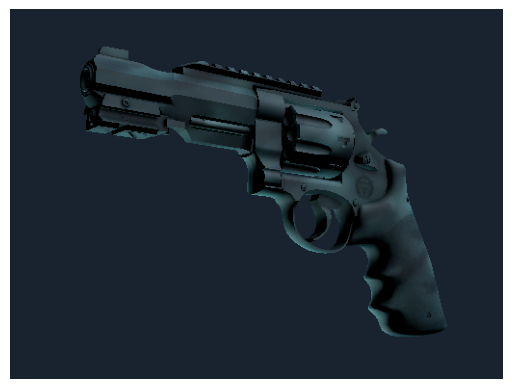

This gun looks like a(n) P250
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/Negev/weapon_negev_sp_nuclear_pattern3_negev_light_large.2d4cd96f9a94367d4c22991250eb9350437d8be6.png


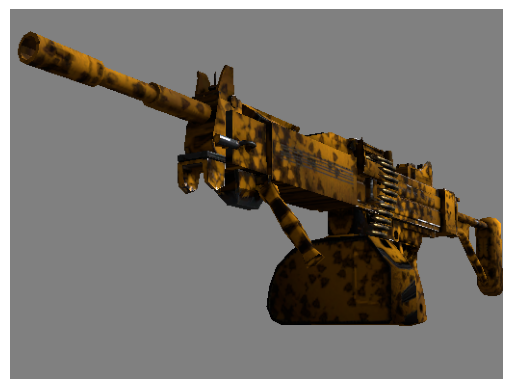

This gun looks like a(n) P-90
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/Galil-AR/weapon_galilar_sp_spray_desert_sage_light_large.34f1268c2cf12e7794538b7140456d3716d81142.png


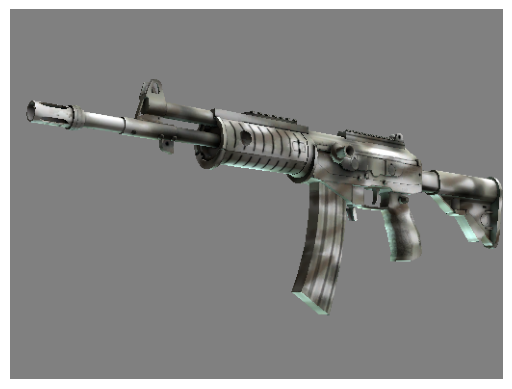

This gun looks like a(n) pp
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/Mag-7/weapon_mag7_sp_mag7_firebitten_light_large.640af2edb52a7f170620e175ddaa5f5cf763325b.png


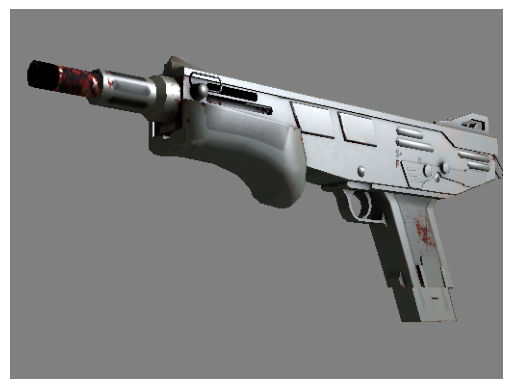

This gun looks like a(n) MP-9
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/P-90/weapon_p90_sp_twigs_light_large.32f929b66cdf34997897a48260a53946e786a531.png


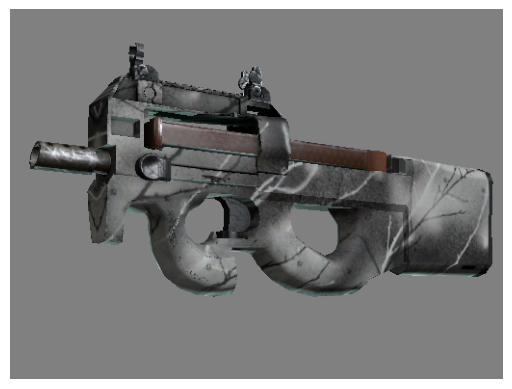

This gun looks like a(n) P-90

Accuracy: 5.00% (1/20)


In [10]:
loop_run_app(test_imgs, model_scratch)

- It looks like our custom CNN architecture result in bad decisions with only 2/20 correct
- Try using a pretrained Resnet50 model

In [11]:
import torchvision.models as models
import torch.nn as nn
from torchvision.models import ResNet50_Weights
# Use ResNet-50 with pre-trained weights
model_transfer = models.resnet50(weights=ResNet50_Weights.DEFAULT)

for param in model_transfer.parameters():
    param.requires_grad = False

model_transfer.fc = nn.Linear(2048, 33)

for param in model_transfer.fc.parameters():
    param.requires_grad = True

if use_cuda:
    model_transfer = model_transfer.cuda()
    
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 164MB/s]


In [12]:
train(100, loaders, model_transfer, optimizer_transfer,
      criterion_transfer, use_cuda)

Epoch: 1 	Training Loss: 3.335421
Epoch: 2 	Training Loss: 2.837399
Epoch: 3 	Training Loss: 2.473277
Epoch: 4 	Training Loss: 2.207106
Epoch: 5 	Training Loss: 1.927448
Epoch: 6 	Training Loss: 1.727584
Epoch: 7 	Training Loss: 1.605582
Epoch: 8 	Training Loss: 1.457405
Epoch: 9 	Training Loss: 1.305440
Epoch: 10 	Training Loss: 1.236238
Epoch: 11 	Training Loss: 1.131369
Epoch: 12 	Training Loss: 1.002919
Epoch: 13 	Training Loss: 0.971659
Epoch: 14 	Training Loss: 0.952037
Epoch: 15 	Training Loss: 0.839989
Epoch: 16 	Training Loss: 0.810840
Epoch: 17 	Training Loss: 0.756811
Epoch: 18 	Training Loss: 0.731839
Epoch: 19 	Training Loss: 0.693127
Epoch: 20 	Training Loss: 0.659147
Epoch: 21 	Training Loss: 0.616778
Epoch: 22 	Training Loss: 0.592941
Epoch: 23 	Training Loss: 0.575632
Epoch: 24 	Training Loss: 0.541524
Epoch: 25 	Training Loss: 0.511320
Epoch: 26 	Training Loss: 0.507294
Epoch: 27 	Training Loss: 0.453955
Epoch: 28 	Training Loss: 0.482017
Epoch: 29 	Training Loss: 0.4

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
test(loaders, model_transfer, criterion_transfer, use_cuda)

Test Loss: 2.530821


Test Accuracy: 42% (28/66)


Evaluating image: /kaggle/input/csgo-guns-dataset/Test/Five_Seven/weapon_fiveseven_so_red_light_large.29ae7b2264bd2a390ecf51a51293d2c2202fdea9.png


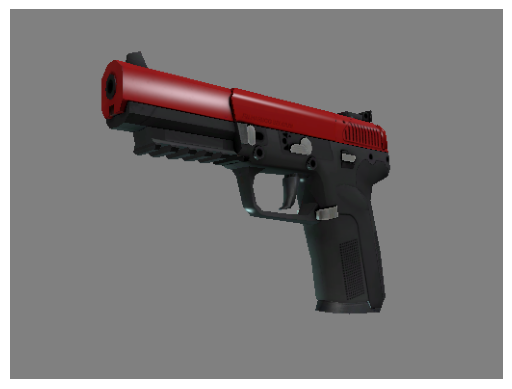

This gun looks like a(n) Nova
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/M4A1/weapon_m4a1_silencer_hy_varicamo_light_large.794803daec1d6d6cd2c47d8e8520d9f5f0b1fc1b.png


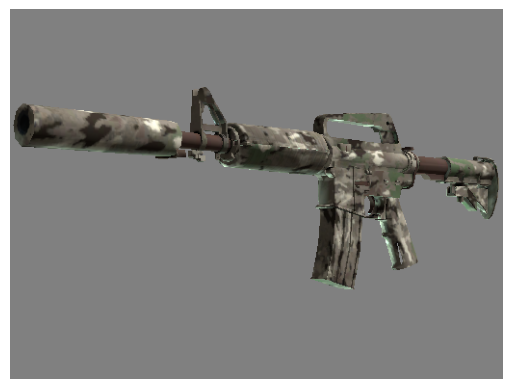

This gun looks like a(n) Nova
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/UMP/weapon_ump45_sp_ump45_d-visions_light_large.33ae7e9e8bf24ee97f4f3d3ee113e51782a756fa.png


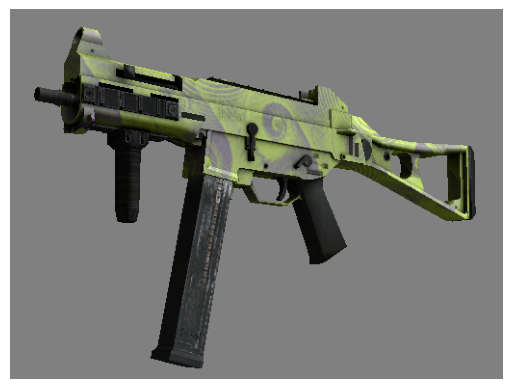

This gun looks like a(n) UMP
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/Aug/weapon_aug_sp_nukestripe_orange_aug_light_large.4309138bd5b9e518628d517a275747ec9c2207d3.jpg


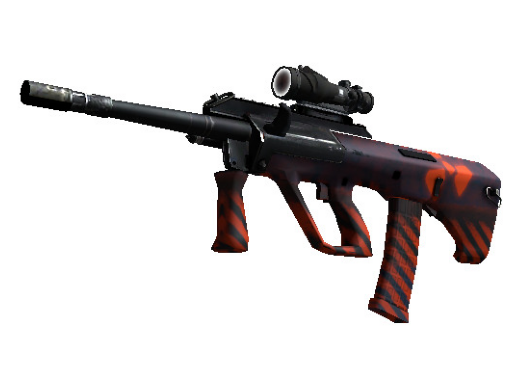

This gun looks like a(n) AK-47
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/MP-5/weapon_mp5sd_sp_tape_short_rally_light_large.2fdb10eba1dbf17030a2c0867fc385fe0449b974.png


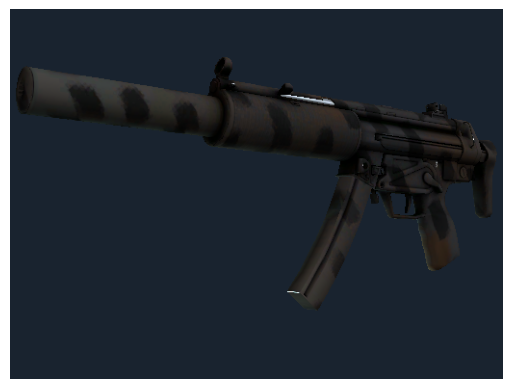

This gun looks like a(n) MP-5
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/MAC-10/weapon_mac10_sp_palm_light_large.22a3296d079e27cb7bb291e15eff10c29aa89b3e.png


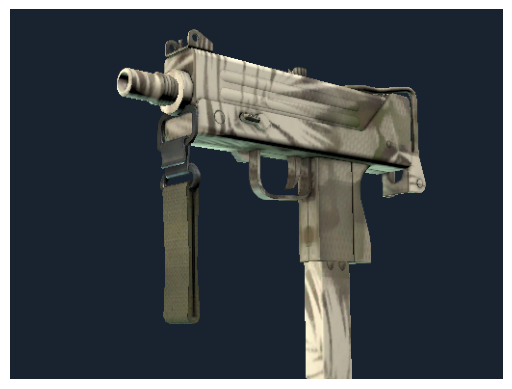

This gun looks like a(n) UMP
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/Sawed-Off/weapon_sawedoff_sp_spray_desert_sage_light_large.e944ddb90e97199d1f274c481462a3a660b9fc5a.png


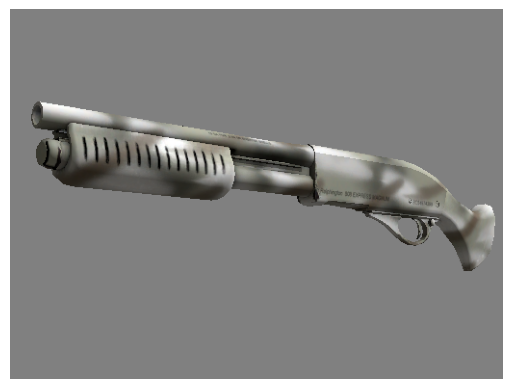

This gun looks like a(n) Sawed-Off
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/MP-7/weapon_mp7_sp_tape_orange_light_large.5870d3d214c5b4cd923d68c4a016b72596808db1.png


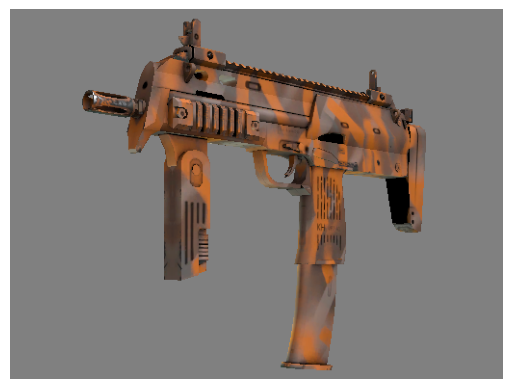

This gun looks like a(n) UMP
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/P-2000/weapon_hkp2000_sp_leaves_grassland_light_large.a7885e449e09718b530a5f8e4b79a30931f104cb.png


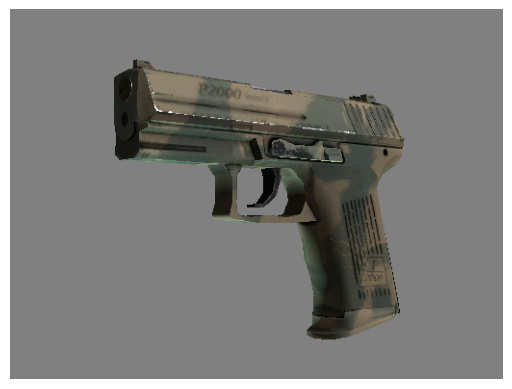

This gun looks like a(n) P-2000
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/G3SG1/weapon_g3sg1_sp_tape_short_jungle_light_large.02fd06db8f950789b6c4bff265df06439382c585.png


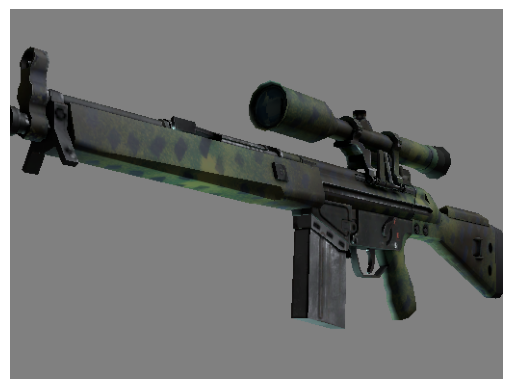

This gun looks like a(n) M4A1
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/dual_pistol/weapon_elite_sp_elites_winter_raider_light_large.eddc2e91d0081e57588b745589209094a6b3e9b6.jpg


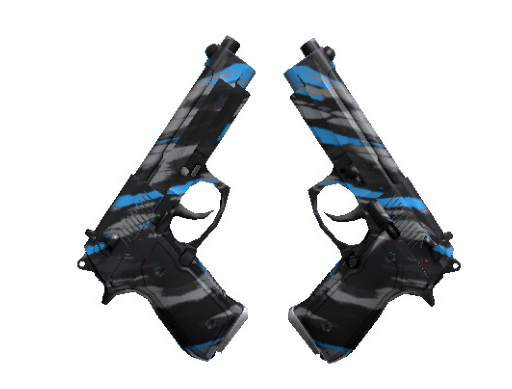

This gun looks like a(n) P-2000
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/P250/weapon_p250_sp_splash_p250_light_large.9270d8d14c39aef83407ea50e51f0eb89c17263d.png


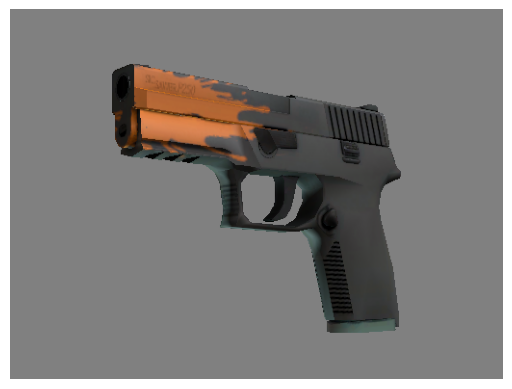

This gun looks like a(n) Nova
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/M249/weapon_m249_sp_mesh_python_light_large.39f20f5499a7d68e8b90a9e064c993e9a803d721.png


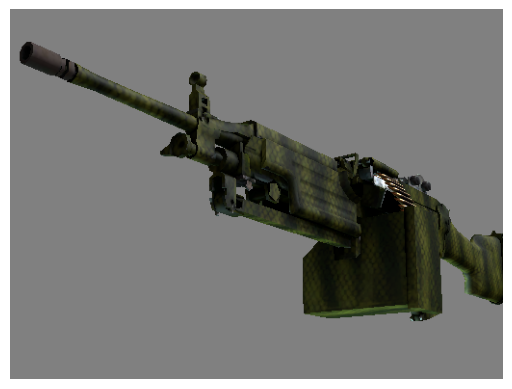

This gun looks like a(n) Mag-7
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/USP/weapon_usp_silencer_sp_leaves_light_large.a71c8dc482fea4aaa1c6b5c115e370a7e134ddfd.png


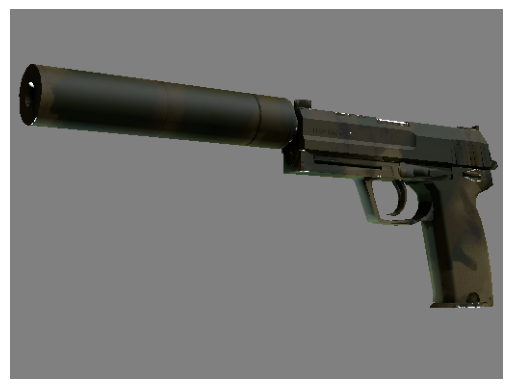

This gun looks like a(n) USP
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/Scar-20/weapon_scar20_sp_palm_light_large.ed935d932711961605c3b03b896560f4ebfe8861.png


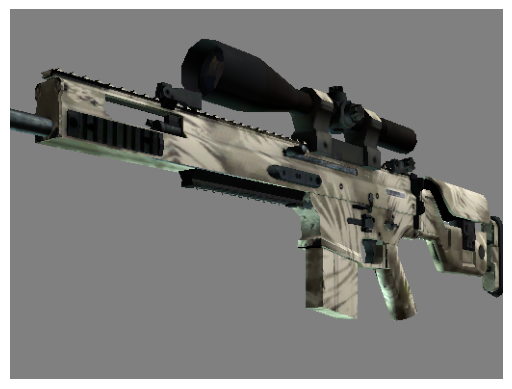

This gun looks like a(n) M4A4
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/Revolver/weapon_revolver_sp_spray_water_light_large.0f7d074b7c53419d9475b0eb68e7215d7f9dcc66.png


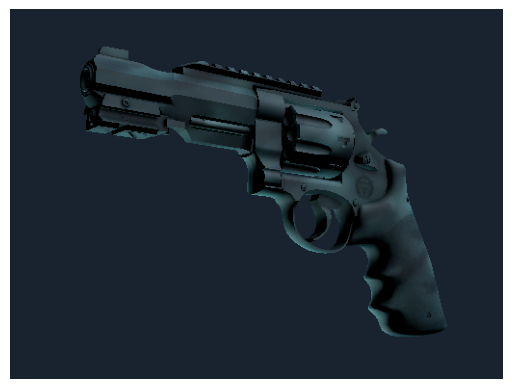

This gun looks like a(n) Revolver
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/Negev/weapon_negev_sp_nuclear_pattern3_negev_light_large.2d4cd96f9a94367d4c22991250eb9350437d8be6.png


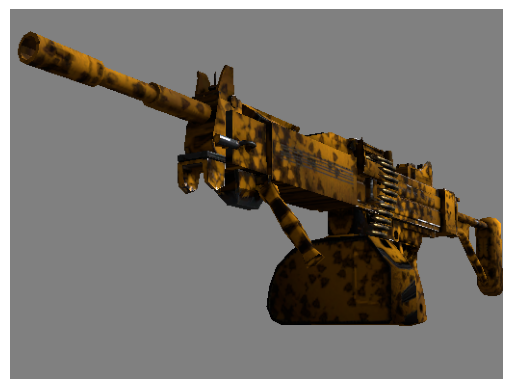

This gun looks like a(n) Negev
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/Galil-AR/weapon_galilar_sp_spray_desert_sage_light_large.34f1268c2cf12e7794538b7140456d3716d81142.png


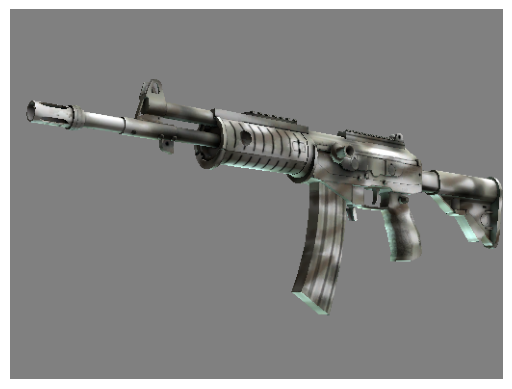

This gun looks like a(n) Galil-AR
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/Mag-7/weapon_mag7_sp_mag7_firebitten_light_large.640af2edb52a7f170620e175ddaa5f5cf763325b.png


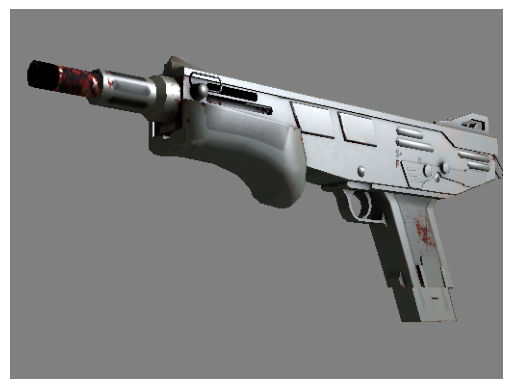

This gun looks like a(n) Nova
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/P-90/weapon_p90_sp_twigs_light_large.32f929b66cdf34997897a48260a53946e786a531.png


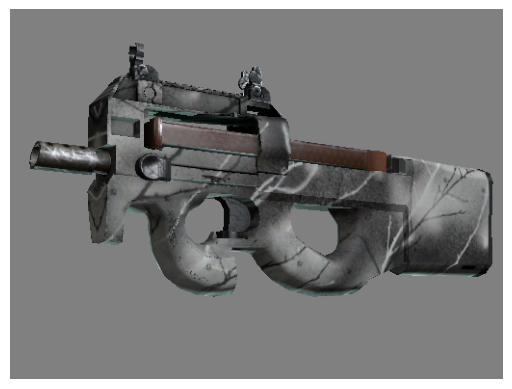

This gun looks like a(n) pp

Accuracy: 40.00% (8/20)


In [14]:
loop_run_app(test_imgs, model_transfer)

- Looks like the Resnet50 model, which is a traditional model in CNN, is quite better than the our custom model with 40%, but it not above average. Let's try another model called EfficientV2

In [15]:
# Install and import necessary libraries
import timm
import torch
import torch.nn as nn
import torch.optim as optim

# Use EfficientNetV2 model for transfer learning
efficient_model = timm.create_model('tf_efficientnetv2_s.in1k', pretrained=True)  # 'efficientnetv2_s' is a smaller version

# Freeze all parameters except the final fully connected layer
for param in efficient_model.parameters():
    param.requires_grad = False

# Replace the final classification layer to match the number of classes (33 in this case)
# EfficientNetV2's output feature size is 1280 for the 'efficientnetv2_s' model.
efficient_model.classifier = nn.Linear(1280, 33)  # Adjust the input size if using a different EfficientNetV2 variant

# Ensure that the parameters of the classifier layer are trainable
for param in efficient_model.classifier.parameters():
    param.requires_grad = True

# Move the model to the GPU if available
if use_cuda:
    efficient_model = efficient_model.cuda()

# Define loss function and optimizer
criterion_efficient = nn.CrossEntropyLoss()
optimizer_efficient = optim.Adam(efficient_model.classifier.parameters(), lr=0.001)

model.safetensors:   0%|          | 0.00/86.5M [00:00<?, ?B/s]

In [16]:
train(100, loaders, efficient_model, optimizer_efficient,
      criterion_efficient, use_cuda)

Epoch: 1 	Training Loss: 3.217826
Epoch: 2 	Training Loss: 2.590346
Epoch: 3 	Training Loss: 2.107118
Epoch: 4 	Training Loss: 1.749611
Epoch: 5 	Training Loss: 1.509068
Epoch: 6 	Training Loss: 1.308987
Epoch: 7 	Training Loss: 1.147980
Epoch: 8 	Training Loss: 1.015285
Epoch: 9 	Training Loss: 0.882939
Epoch: 10 	Training Loss: 0.839683
Epoch: 11 	Training Loss: 0.782127
Epoch: 12 	Training Loss: 0.770350
Epoch: 13 	Training Loss: 0.688860
Epoch: 14 	Training Loss: 0.615149
Epoch: 15 	Training Loss: 0.588516
Epoch: 16 	Training Loss: 0.545520
Epoch: 17 	Training Loss: 0.517843
Epoch: 18 	Training Loss: 0.497865
Epoch: 19 	Training Loss: 0.487496
Epoch: 20 	Training Loss: 0.479281
Epoch: 21 	Training Loss: 0.459413
Epoch: 22 	Training Loss: 0.417995
Epoch: 23 	Training Loss: 0.436919
Epoch: 24 	Training Loss: 0.377301
Epoch: 25 	Training Loss: 0.350297
Epoch: 26 	Training Loss: 0.360844
Epoch: 27 	Training Loss: 0.350889
Epoch: 28 	Training Loss: 0.334357
Epoch: 29 	Training Loss: 0.3

EfficientNet(
  (conv_stem): Conv2dSame(3, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path): Identity()
      )
      (1): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path):

In [17]:
test(loaders, efficient_model, criterion_efficient, use_cuda)

Test Loss: 0.873932


Test Accuracy: 71% (47/66)


Evaluating image: /kaggle/input/csgo-guns-dataset/Test/Five_Seven/weapon_fiveseven_so_red_light_large.29ae7b2264bd2a390ecf51a51293d2c2202fdea9.png


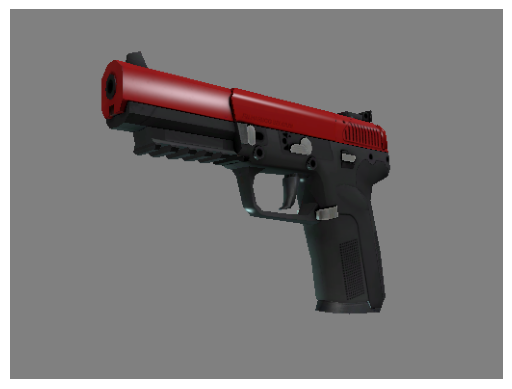

This gun looks like a(n) dual_pistol
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/M4A1/weapon_m4a1_silencer_hy_varicamo_light_large.794803daec1d6d6cd2c47d8e8520d9f5f0b1fc1b.png


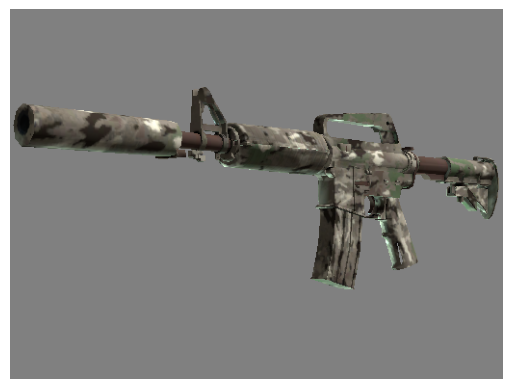

This gun looks like a(n) M4A1
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/UMP/weapon_ump45_sp_ump45_d-visions_light_large.33ae7e9e8bf24ee97f4f3d3ee113e51782a756fa.png


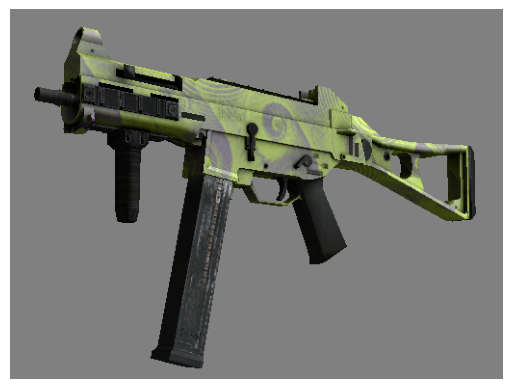

This gun looks like a(n) UMP
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/Aug/weapon_aug_sp_nukestripe_orange_aug_light_large.4309138bd5b9e518628d517a275747ec9c2207d3.jpg


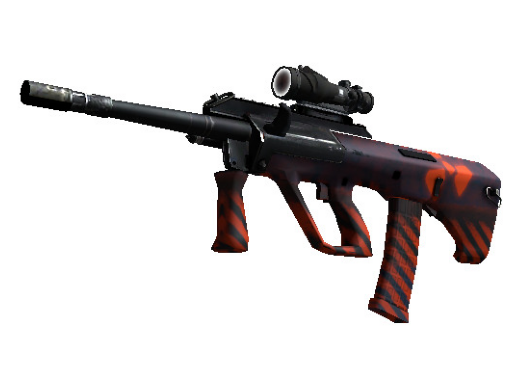

This gun looks like a(n) Aug
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/MP-5/weapon_mp5sd_sp_tape_short_rally_light_large.2fdb10eba1dbf17030a2c0867fc385fe0449b974.png


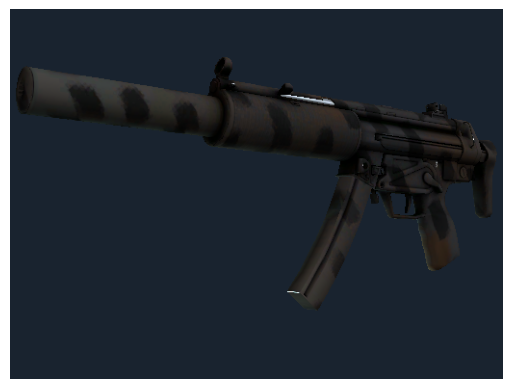

This gun looks like a(n) Negev
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/MAC-10/weapon_mac10_sp_palm_light_large.22a3296d079e27cb7bb291e15eff10c29aa89b3e.png


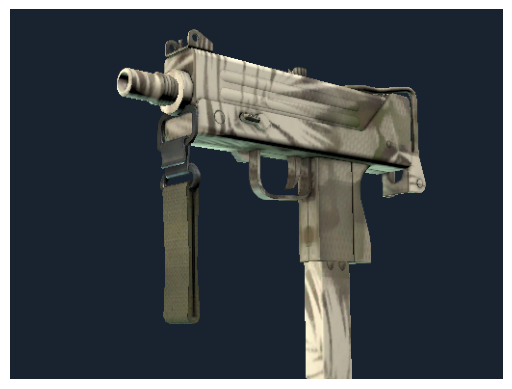

This gun looks like a(n) MAC-10
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/Sawed-Off/weapon_sawedoff_sp_spray_desert_sage_light_large.e944ddb90e97199d1f274c481462a3a660b9fc5a.png


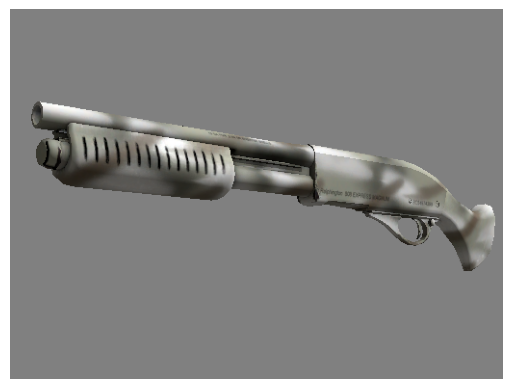

This gun looks like a(n) Revolver
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/MP-7/weapon_mp7_sp_tape_orange_light_large.5870d3d214c5b4cd923d68c4a016b72596808db1.png


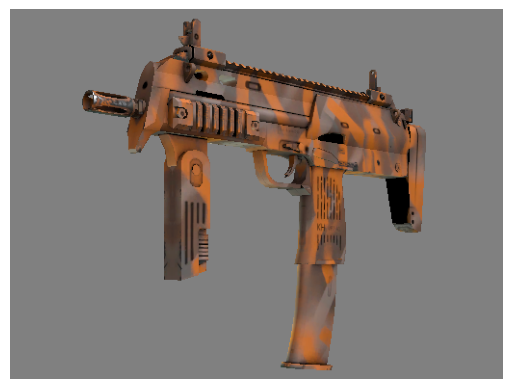

This gun looks like a(n) MP-7
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/P-2000/weapon_hkp2000_sp_leaves_grassland_light_large.a7885e449e09718b530a5f8e4b79a30931f104cb.png


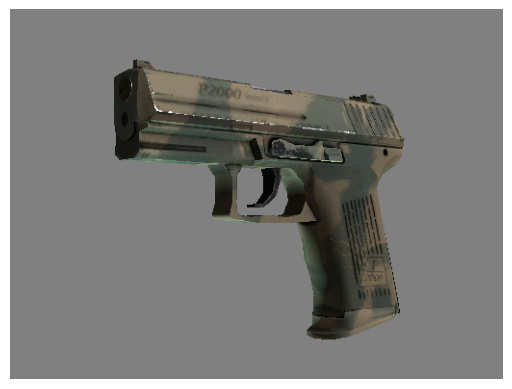

This gun looks like a(n) MP-7
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/G3SG1/weapon_g3sg1_sp_tape_short_jungle_light_large.02fd06db8f950789b6c4bff265df06439382c585.png


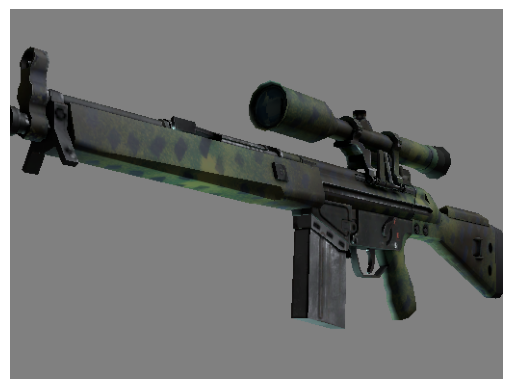

This gun looks like a(n) Scar-20
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/dual_pistol/weapon_elite_sp_elites_winter_raider_light_large.eddc2e91d0081e57588b745589209094a6b3e9b6.jpg


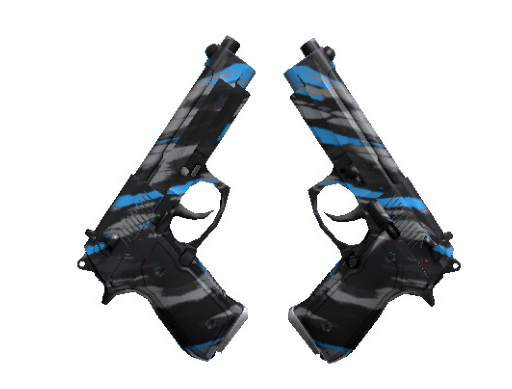

This gun looks like a(n) dual_pistol
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/P250/weapon_p250_sp_splash_p250_light_large.9270d8d14c39aef83407ea50e51f0eb89c17263d.png


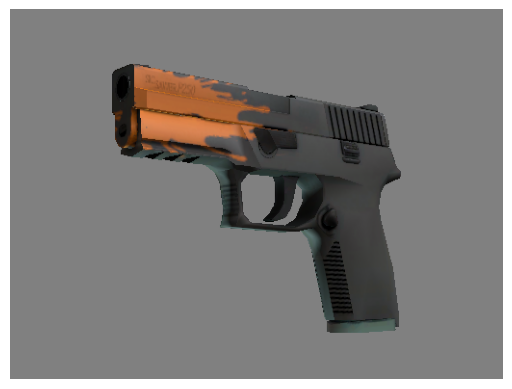

This gun looks like a(n) P250
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/M249/weapon_m249_sp_mesh_python_light_large.39f20f5499a7d68e8b90a9e064c993e9a803d721.png


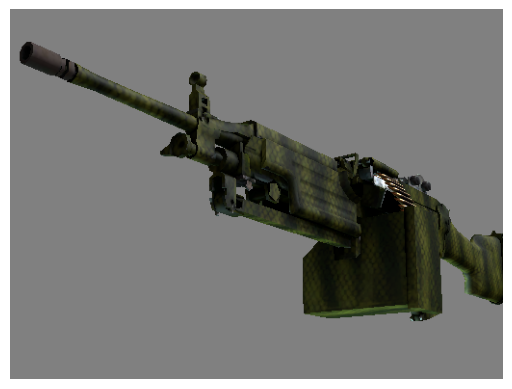

This gun looks like a(n) M249
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/USP/weapon_usp_silencer_sp_leaves_light_large.a71c8dc482fea4aaa1c6b5c115e370a7e134ddfd.png


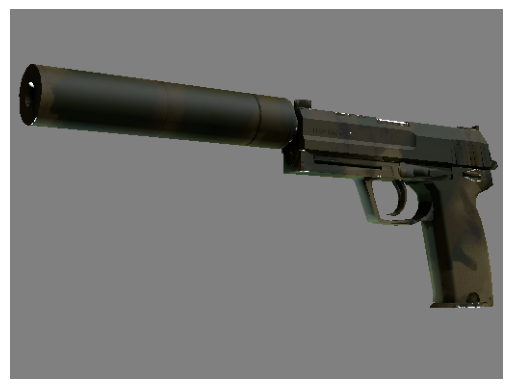

This gun looks like a(n) USP
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/Scar-20/weapon_scar20_sp_palm_light_large.ed935d932711961605c3b03b896560f4ebfe8861.png


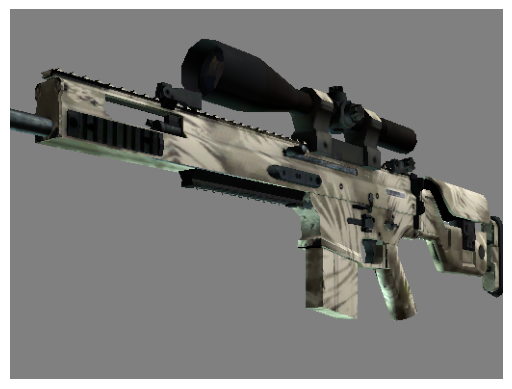

This gun looks like a(n) Scar-20
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/Revolver/weapon_revolver_sp_spray_water_light_large.0f7d074b7c53419d9475b0eb68e7215d7f9dcc66.png


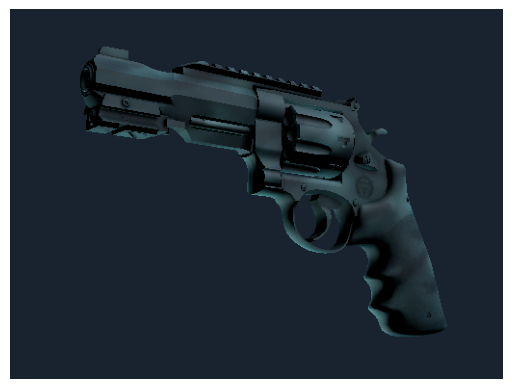

This gun looks like a(n) Revolver
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/Negev/weapon_negev_sp_nuclear_pattern3_negev_light_large.2d4cd96f9a94367d4c22991250eb9350437d8be6.png


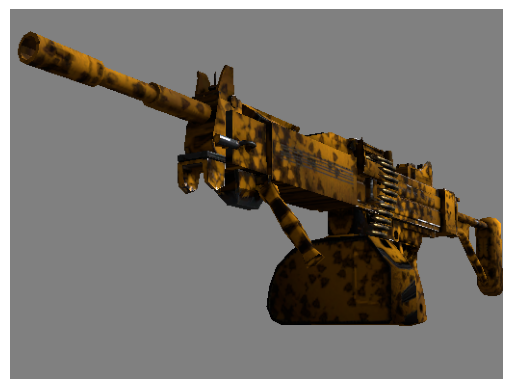

This gun looks like a(n) Negev
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/Galil-AR/weapon_galilar_sp_spray_desert_sage_light_large.34f1268c2cf12e7794538b7140456d3716d81142.png


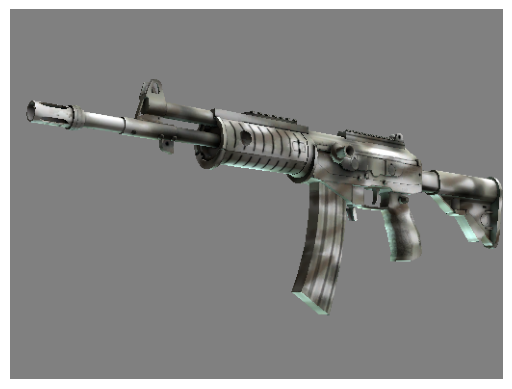

This gun looks like a(n) Galil-AR
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/Mag-7/weapon_mag7_sp_mag7_firebitten_light_large.640af2edb52a7f170620e175ddaa5f5cf763325b.png


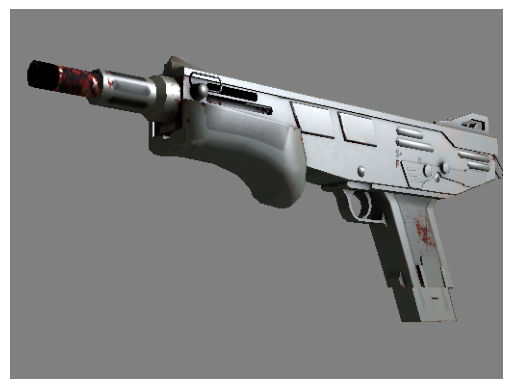

This gun looks like a(n) Mag-7
Evaluating image: /kaggle/input/csgo-guns-dataset/Test/P-90/weapon_p90_sp_twigs_light_large.32f929b66cdf34997897a48260a53946e786a531.png


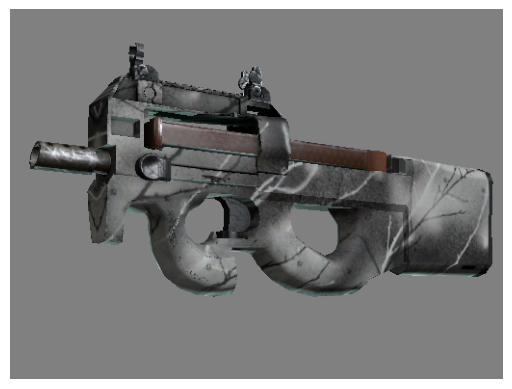

This gun looks like a(n) P-90

Accuracy: 75.00% (15/20)


In [18]:
loop_run_app(test_imgs, efficient_model)

With using EfficientV2 Model, we can achieve Accuracy of 71% on test set